In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob

import string
import re

import spacy
import nltk
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
print(stopWords[:10])

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [4]:
def count_duplicates(df):

    dic = {
        'Metric': [ 
            'Duplicates in title',
            'Duplicates in text',
            'Duplicates in title or text column'
        ],
        'Count': [
            df.title.duplicated().sum(),
            df.text.duplicated().sum(),
            (df.title.duplicated() | df.text.duplicated()).sum()
        ],
        'Proportion': [
            df[df.title.duplicated()]['label'].mean() * 100,
            df[df.text.duplicated()]['label'].mean() * 100,
            ((df.title.duplicated() | df.text.duplicated()).sum()) / len(df) *100
        ],
        'Count Fake News': [
            len(df[df.title.duplicated() & df.label == 1]),
            len(df[df.text.duplicated() & df.label == 1]),
            ((df.title.duplicated() | df.text.duplicated()) & (df.label == 1)).sum()
        ],
        'Proportion Fake News': [
            len(df[df.title.duplicated() & df.label == 1]) / len(df) * 100,
            len(df[df.text.duplicated() & df.label == 1]) / len(df) * 100,
            ((df.title.duplicated() | df.text.duplicated()) & (df.label == 1)).sum() / len(df) * 100
        ]
    }
    
    df_result = pd.DataFrame(dic)
    return df_result

In [5]:
def plot_histograms_and_boxplots(df, num_cols):
    """
    Plots histograms and boxplots for given numerical columns.

    Parameters:
    - df (DataFrame): The input DataFrame.
    - num_cols (list): List of numerical column names.

    Returns:
    - None (displays the plots)
    """
    fig, ax = plt.subplots(nrows=len(num_cols), ncols=2, figsize=[15, len(num_cols) * 3])

    for i, col in enumerate(num_cols):
        # Histogram with KDE for label categories
        sns.histplot(df[col][df.label == 1], ax=ax[i][0], label="Fake", kde=True, alpha=0.5)
        sns.histplot(df[col][df.label == 0], ax=ax[i][0], label="Real", kde=True, alpha=0.5)
        ax[i][0].set_title(f'Histogram for {col} (Max: {df[col].max()})')
        ax[i][0].legend()

        # Boxplot
        sns.boxplot(x=df[col], ax=ax[i][1])
        ax[i][1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

In [6]:
def clean_data(df):
    # drop unused column
    df = df.drop(columns='Unnamed: 0')
    # Reverse labels into: fake=1, real=0
    df['label'] = 1 - df['label']
    # Fill Nan-values with an empty string
    df[['title', 'text']] = df[['title', 'text']].fillna("")

    return df

In [7]:
def remove_outliers_mad(df, num_cols, threshold=3, iterations=1):
    """
    Entfernt Ausreißer aus einem DataFrame anhand der Median Absolute Deviation (MAD)
    
    Parameter:
    df : pd.DataFrame - Der Eingabe-DataFrame.
    threshold : float - Der Schwellenwert für MAD (Standard: 3).
    iterations : int - Anzahl der Iterationen, um Ausreißer schrittweise zu entfernen (Standard: 1).
    
    Rückgabe:
    pd.DataFrame - DataFrame ohne Ausreißer.
    """
    df_clean = df.copy()
    
    for _ in range(iterations):
        median = df_clean[num_cols].median()
        mad = (df_clean[num_cols] - median).abs().median()

        mad_distance = (df_clean[num_cols] - median).abs() / mad
        df_clean = df_clean[(mad_distance < threshold).all(axis=1)]
    
    return df_clean

In [8]:
def plot_WordCloud(text):
    wordcloud = WordCloud(
        stopwords=stopWords,
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [36]:
# `text_cleaner` function
def text_cleaner(sentence):
    """Clean the text using NLP-Steps.
 
    Steps include: Lemmatization, removing stop words, removing punctuations 
 
    Args:
        sentence (str): The uncleaned text.
 
    Returns:
        str: The cleaned text.
        
    """

    # Create the Doc object named `text` from `sentence` using `nlp()`
    doc = nlp(sentence)
    # Lemmatization
    lemma_token = [token.lemma_ for token in doc if token.pos_ != 'PRON']
    # Remove stop words and converting tokens to lowercase
    no_stopWords_lemma_token = [token.lower() for token in lemma_token if token not in stopWords]
    # Remove punctuations
    clean_doc = [token for token in no_stopWords_lemma_token if token not in punctuations]
    # Use the `.join` method on `text` to convert string
    joined_clean_doc = " ".join(clean_doc)
    # Use `re.sub()` to substitute multiple spaces or dots`[\.\s]+` to single space `' '
    sub_doc = re.sub('[\.\s]+', ' ', joined_clean_doc)
    # Use `re.sub()` to substitute ■ to an empty string `' '
    final_doc = re.sub(r'[\■🚨]+', '', sub_doc)
    return final_doc

# Data preparation

In [61]:
df = pd.read_csv('./data/WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [62]:
# drop unused column
df = df.drop(columns='Unnamed: 0')
# Reverse labels into: fake=1, real=0
df['label'] = 1 - df['label']

Create new features for EDA:

- title_text: concatenate columns title and text
- text_word_count: # of words in text column
- title_word_count: # of words in title column
- text_unique_words: # of uniqe words in text column
- text_char_count: # of characters in text column
- title_char_count: # of characters in title column
- avg_word_length: average word length in text column
- sentence_count: # of sentences in text column
- special_char_count: # of special characters in text column
- language: estimated language for text column

In [ ]:
# df = prepare_features(df)

In [64]:
path = './data/df_prepared_features.csv'
with open(path, 'w', encoding='utf-8', newline='') as file:
    df.to_csv(file, index=False)

print(f"CSV file was successfully saved under: {path}")

CSV file was successfully saved under: ./data/df_prepared_features.csv


In [9]:
with open('./data/df_prepared_features.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file)

df.head()

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,language
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,en
1,NaN,Did they post their votes for Hillary already?,0,NaN,8,0,8,39,0,4.875000,1,1,en
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,en
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,en
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,en


In [10]:
num_cols = df.select_dtypes(include=['number']).columns.drop('label')
cat_cols = df.select_dtypes(include=['object']).columns

# Exploratory Data Analysis

In [9]:
print('First rows of the dataset:\n')
df.head(10)

First rows of the dataset:



,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,language
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,en
1,NaN,Did they post their votes for Hillary already?,0,NaN,8,0,8,39,0,4.875000,1,1,en
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,en
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,en
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,en
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,0,About Time! Christian Group Sues Amazon and SP...,244,13,153,1276,66,5.229508,13,41,en
6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,0,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,15,20,15,66,86,4.400000,2,2,en
7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,0,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,0,12,0,0,68,0.000000,0,0,unknown
8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",0,Sports Bar Owner Bans NFL Games…Will Show Only...,265,19,173,1170,98,4.415094,14,33,en
9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",0,Latest Pipeline Leak Underscores Dangers Of Da...,485,9,308,2535,58,5.202062,28,122,en


In [12]:
print('General informations\n')
print(df.info())

General informations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               71576 non-null  object 
 1   text                72095 non-null  object 
 2   label               72134 non-null  int64  
 3   title_text          71537 non-null  object 
 4   text_word_count     72134 non-null  int64  
 5   title_word_count    72134 non-null  int64  
 6   text_unique_words   72134 non-null  int64  
 7   text_char_count     72134 non-null  int64  
 8   title_char_count    72134 non-null  int64  
 9   avg_word_length     72134 non-null  float64
 10  sentence_count      72134 non-null  int64  
 11  special_char_count  72134 non-null  int64  
 12  language            72134 non-null  object 
dtypes: float64(1), int64(8), object(4)
memory usage: 7.2+ MB
None


In [13]:
print("Number of missing values per column:\n")
print(df.isnull().sum())

Number of missing values per column:

title                 558
text                   39
label                   0
title_text            597
text_word_count         0
title_word_count        0
text_unique_words       0
text_char_count         0
title_char_count        0
avg_word_length         0
sentence_count          0
special_char_count      0
language                0
dtype: int64


There are entries with zero word length in the data set due to blank entries and missing values.

In [14]:
print('Total number of entries with zero word length in text column:', len(df[df.text_word_count == 0]))

print('\nof which are included of np.nan:', df['text'].isna().sum())
print('of which are included of blank entries:', (df.text[(df['text'] == ' ') | (df['text'] == '  ')].count()))
print('of which are included of \\n entries:', len(df[(df['text'] != ' ') & (df['text'] != '  ') & (df['text'].notna()) & (df['text_word_count'] == 0)]))

Total number of entries with zero word length in text column: 783

of which are included of np.nan: 39
of which are included of blank entries: 743
of which are included of \n entries: 1


In [17]:
print('Total number of entries with zero word length in title column:', len(df[df.title_word_count == 0]))
print('\nof which are included of np.nan:', df['title'].isna().sum())

Total number of entries with zero word length in title column: 558

of which are included of np.nan: 558


# Check categorical features

In [16]:
print("Statistical overview of categorical features:\n")
display(df.describe(include='object'))

Statistical overview of categorical features:



,title,text,title_text,language
count,71576,72095,71537,72134
unique,62347,62718,63121,32
top,Factbox: Trump fills top jobs for his administ...,,Highlights: The Trump presidency on April 13 a...,en
freq,14,738,8,70704


The difference between count and unique indicates the presence of duplicates. A total of 10,740 rows are affected, containing duplicates in either the text or title columns. Removing these would reduce the dataset by 15%.

In [18]:
count_duplicates(df)

,Metric,Count,Proportion,Count Fake News,Proportion Fake News
0,Duplicates in title,9786,6.345800,621,0.860898
1,Duplicates in text,9415,4.333510,408,0.565614
2,Duplicates in title or text column,10740,14.888957,791,1.096570


Approximately 98% of the entries are in English. Given the small proportion of other languages, it is advisable to remove them from the training dataset. Entries labeled as "unknown" consist of blank entries and URLs.

In [19]:
count_ct = pd.crosstab(index=df['language'], columns='Count')
proportion_ct = pd.crosstab(index=df['language'], columns='Proportion', normalize=True)
result = pd.concat([count_ct, proportion_ct], axis=1)
display(pd.DataFrame(result))

col_0,Count,Proportion
language,,
af,2,0.000028
ar,19,0.000263
ca,1,0.000014
cy,2,0.000028
da,1,0.000014
de,110,0.001525
el,2,0.000028
en,70704,0.980176
es,147,0.002038


In [20]:
df[df["language"] == "unknown"]

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,language
7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,0,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,0,12,0,0,68,0.0,0,0,unknown
106,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,0,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,0,10,0,0,59,0.0,0,0,unknown
325,Ohio State University Student Says Terrorist A...,,0,Ohio State University Student Says Terrorist A...,0,13,0,0,87,0.0,0,0,unknown
364,JULIAN ASSANGE REVEALS John Podesta’s Hilariou...,,0,JULIAN ASSANGE REVEALS John Podesta’s Hilariou...,0,16,0,0,99,0.0,0,0,unknown
421,HEATED! TUCKER CARLSON Totally Shuts Down Radi...,https://www.youtube.com/watch?v=RRPSCqkAJgk,0,HEATED! TUCKER CARLSON Totally Shuts Down Radi...,1,17,1,43,94,43.0,4,8,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71771,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,0,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,0,11,0,0,63,0.0,0,0,unknown
71914,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,0,WATCH TUCKER CARLSON Scorch Sanctuary City May...,0,13,0,0,74,0.0,0,0,unknown
72026,BOOM! Woman Tries To Steal TRUMP Signs BUT Thi...,,0,BOOM! Woman Tries To Steal TRUMP Signs BUT Thi...,0,15,0,0,64,0.0,0,0,unknown
72119,BILL O’REILLY Destroys Liberal Pundit On Trump...,,0,BILL O’REILLY Destroys Liberal Pundit On Trump...,0,9,0,0,55,0.0,0,0,unknown


# Check numerical fetaures

The difference between the mean and median across all numerical features suggests the presence of skewed distributions and potential outliers in the dataset. This indicates that some values deviate significantly from the majority, which could impact statistical analyses and model performance.

In [21]:
print("\nStatistical overview of numerical features:\n")
df.describe()


Statistical overview of numerical features:



,label,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count
count,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000
mean,0.485596,540.550933,12.173316,283.921410,2719.158233,65.231555,5.062291,30.532426,97.637647
std,0.499796,625.399748,4.255615,238.942487,3102.965371,21.921910,1.804421,38.268728,496.170294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,227.000000,9.000000,147.000000,1144.000000,53.000000,4.833861,12.000000,32.000000
50%,0.000000,398.000000,12.000000,234.000000,2017.000000,62.000000,5.038491,21.000000,59.000000
75%,1.000000,667.000000,14.000000,358.000000,3377.000000,75.000000,5.242921,37.000000,110.000000
max,1.000000,24234.000000,72.000000,7009.000000,122490.000000,385.000000,149.000000,1562.000000,121808.000000


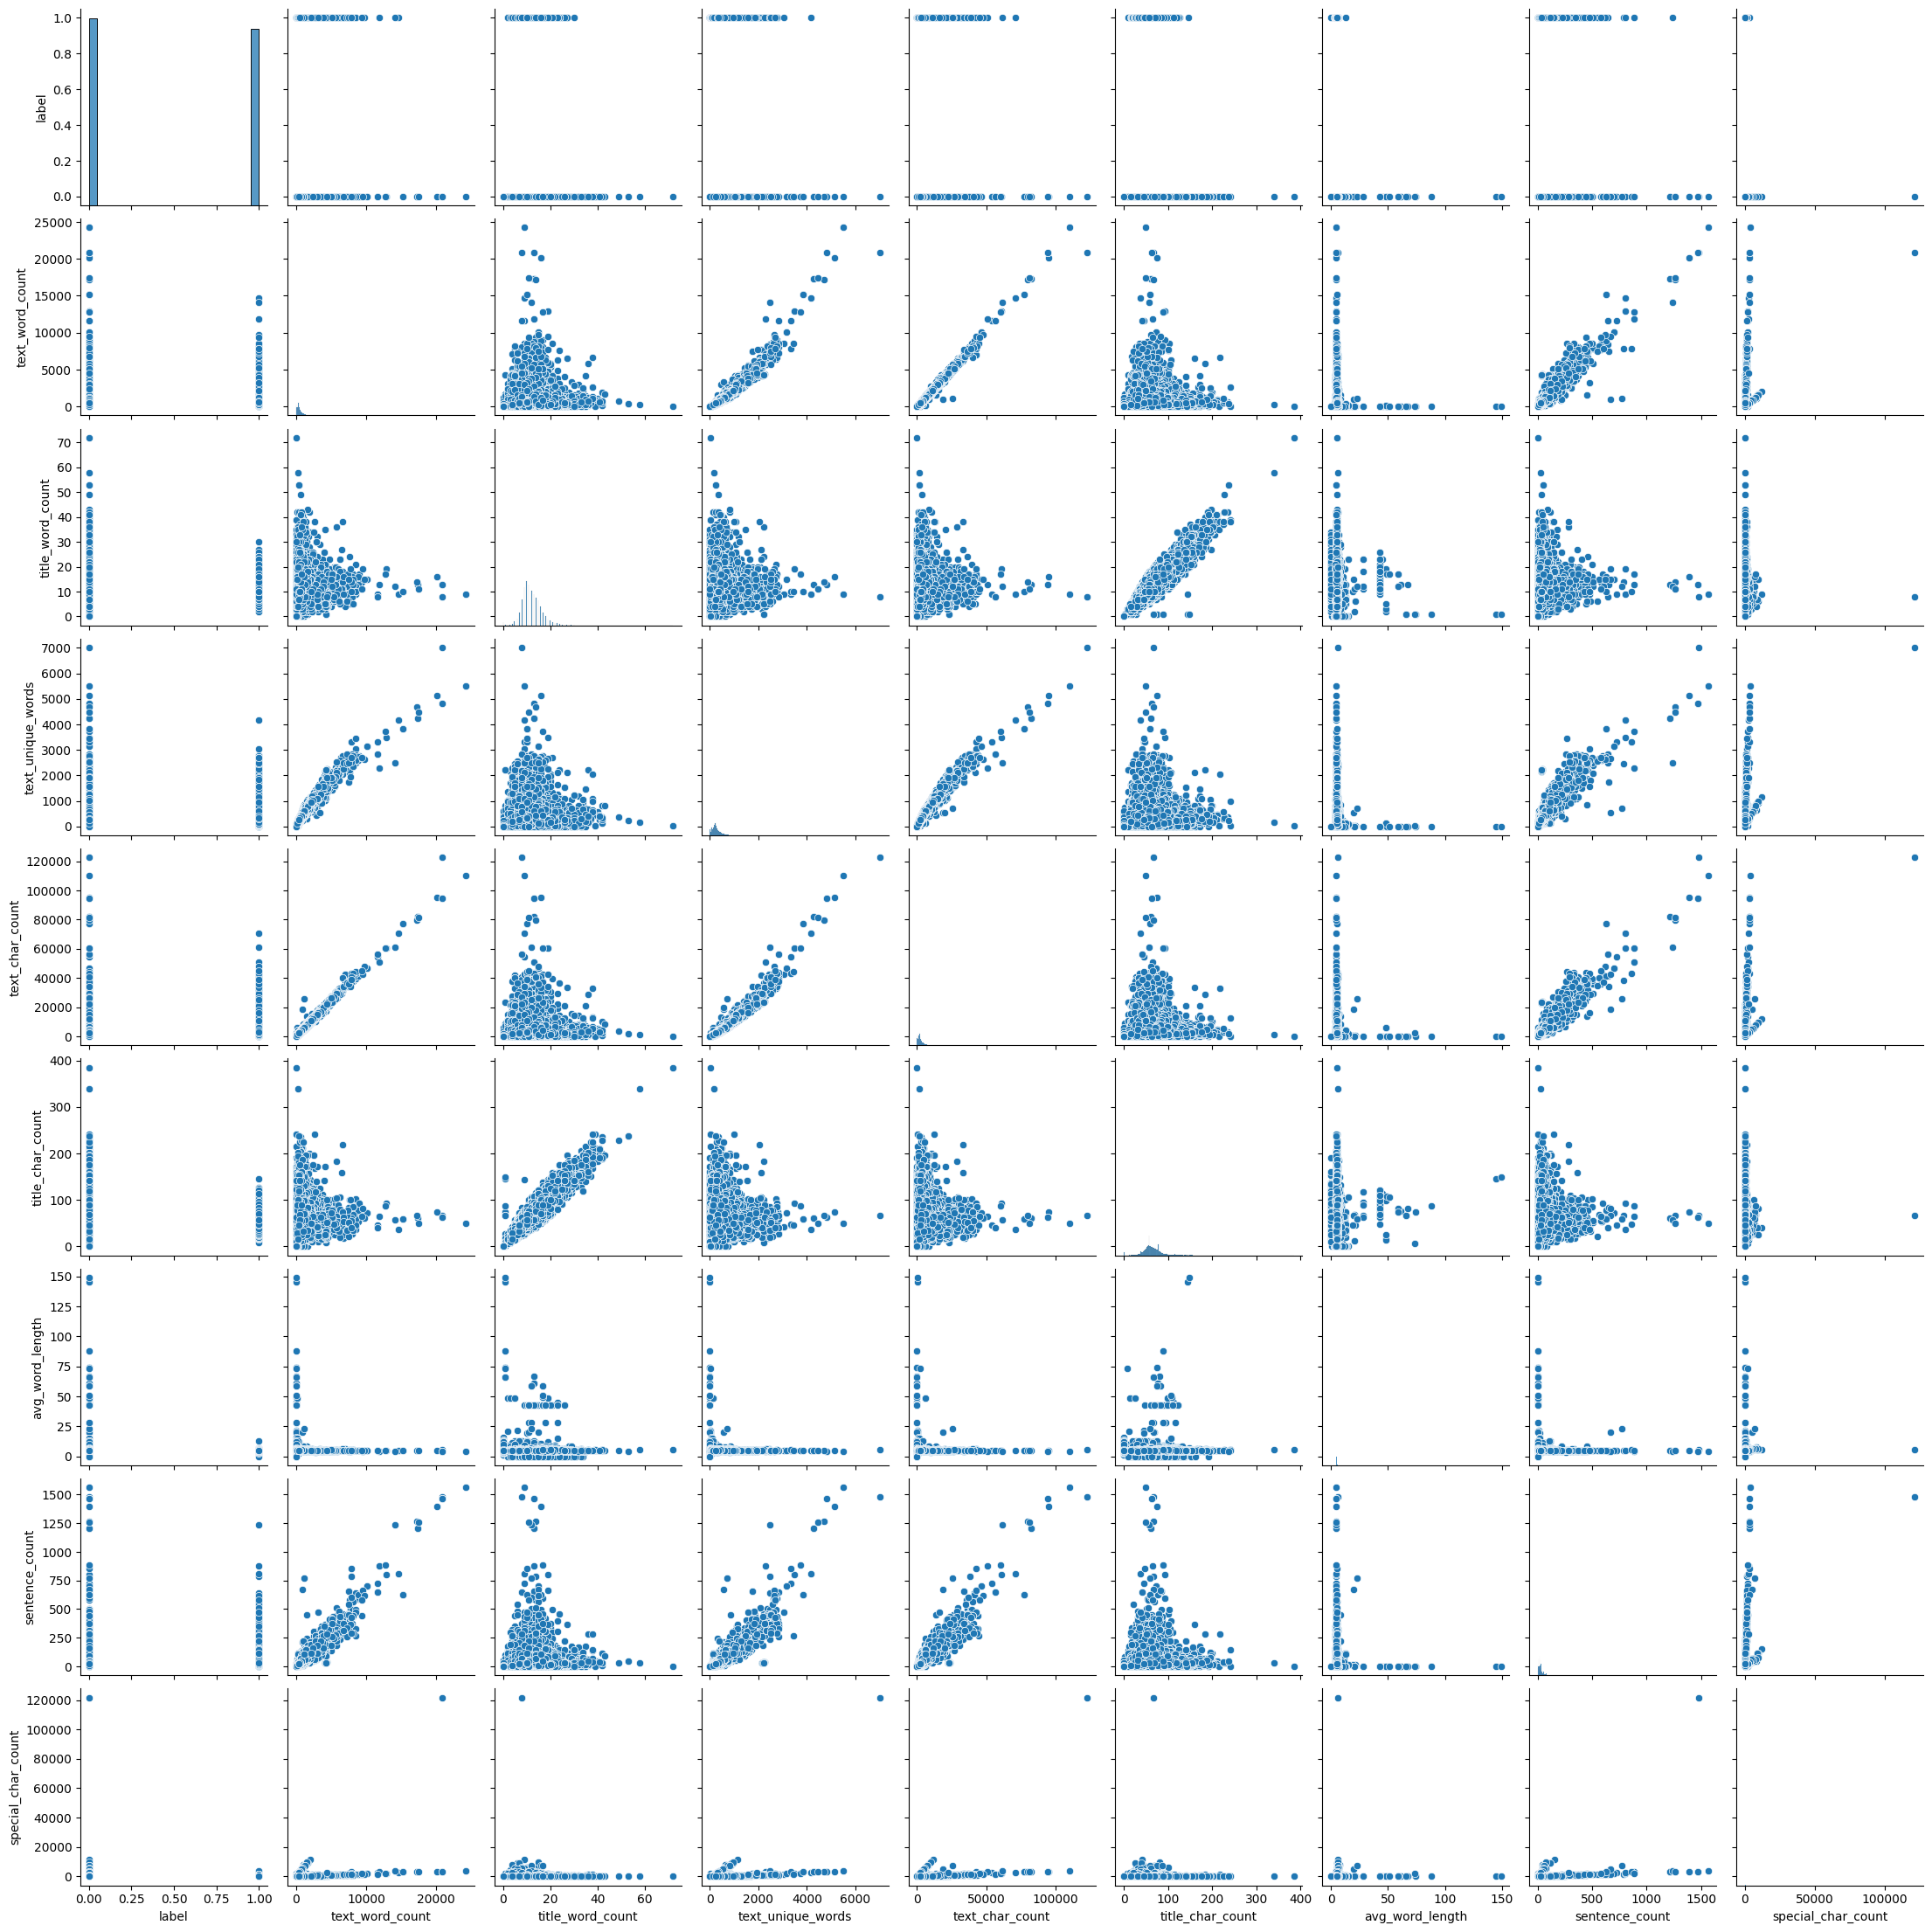

In [35]:
sns.pairplot(df)

label                 1.000000
sentence_count        0.083335
text_unique_words     0.080442
text_char_count       0.058763
text_word_count       0.057582
avg_word_length       0.018049
special_char_count    0.004179
title_word_count     -0.257237
title_char_count     -0.287657
Name: label, dtype: float64

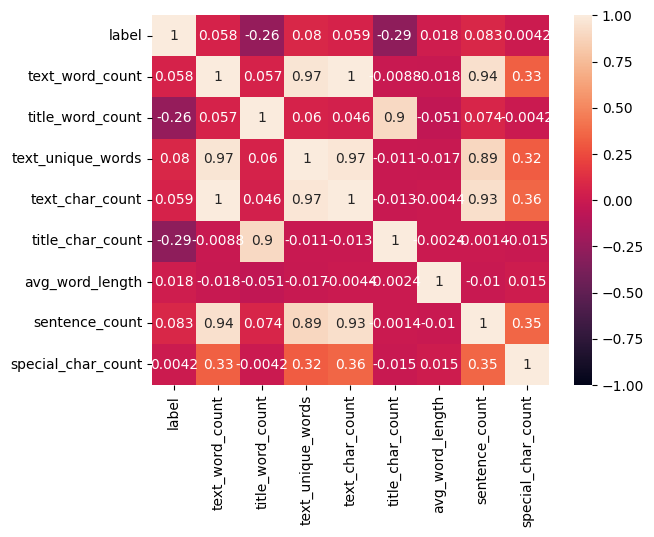

In [28]:
# visualize correlation matrix for numerical variables
df_corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True);

df_corr['label'].sort_values(ascending = False)

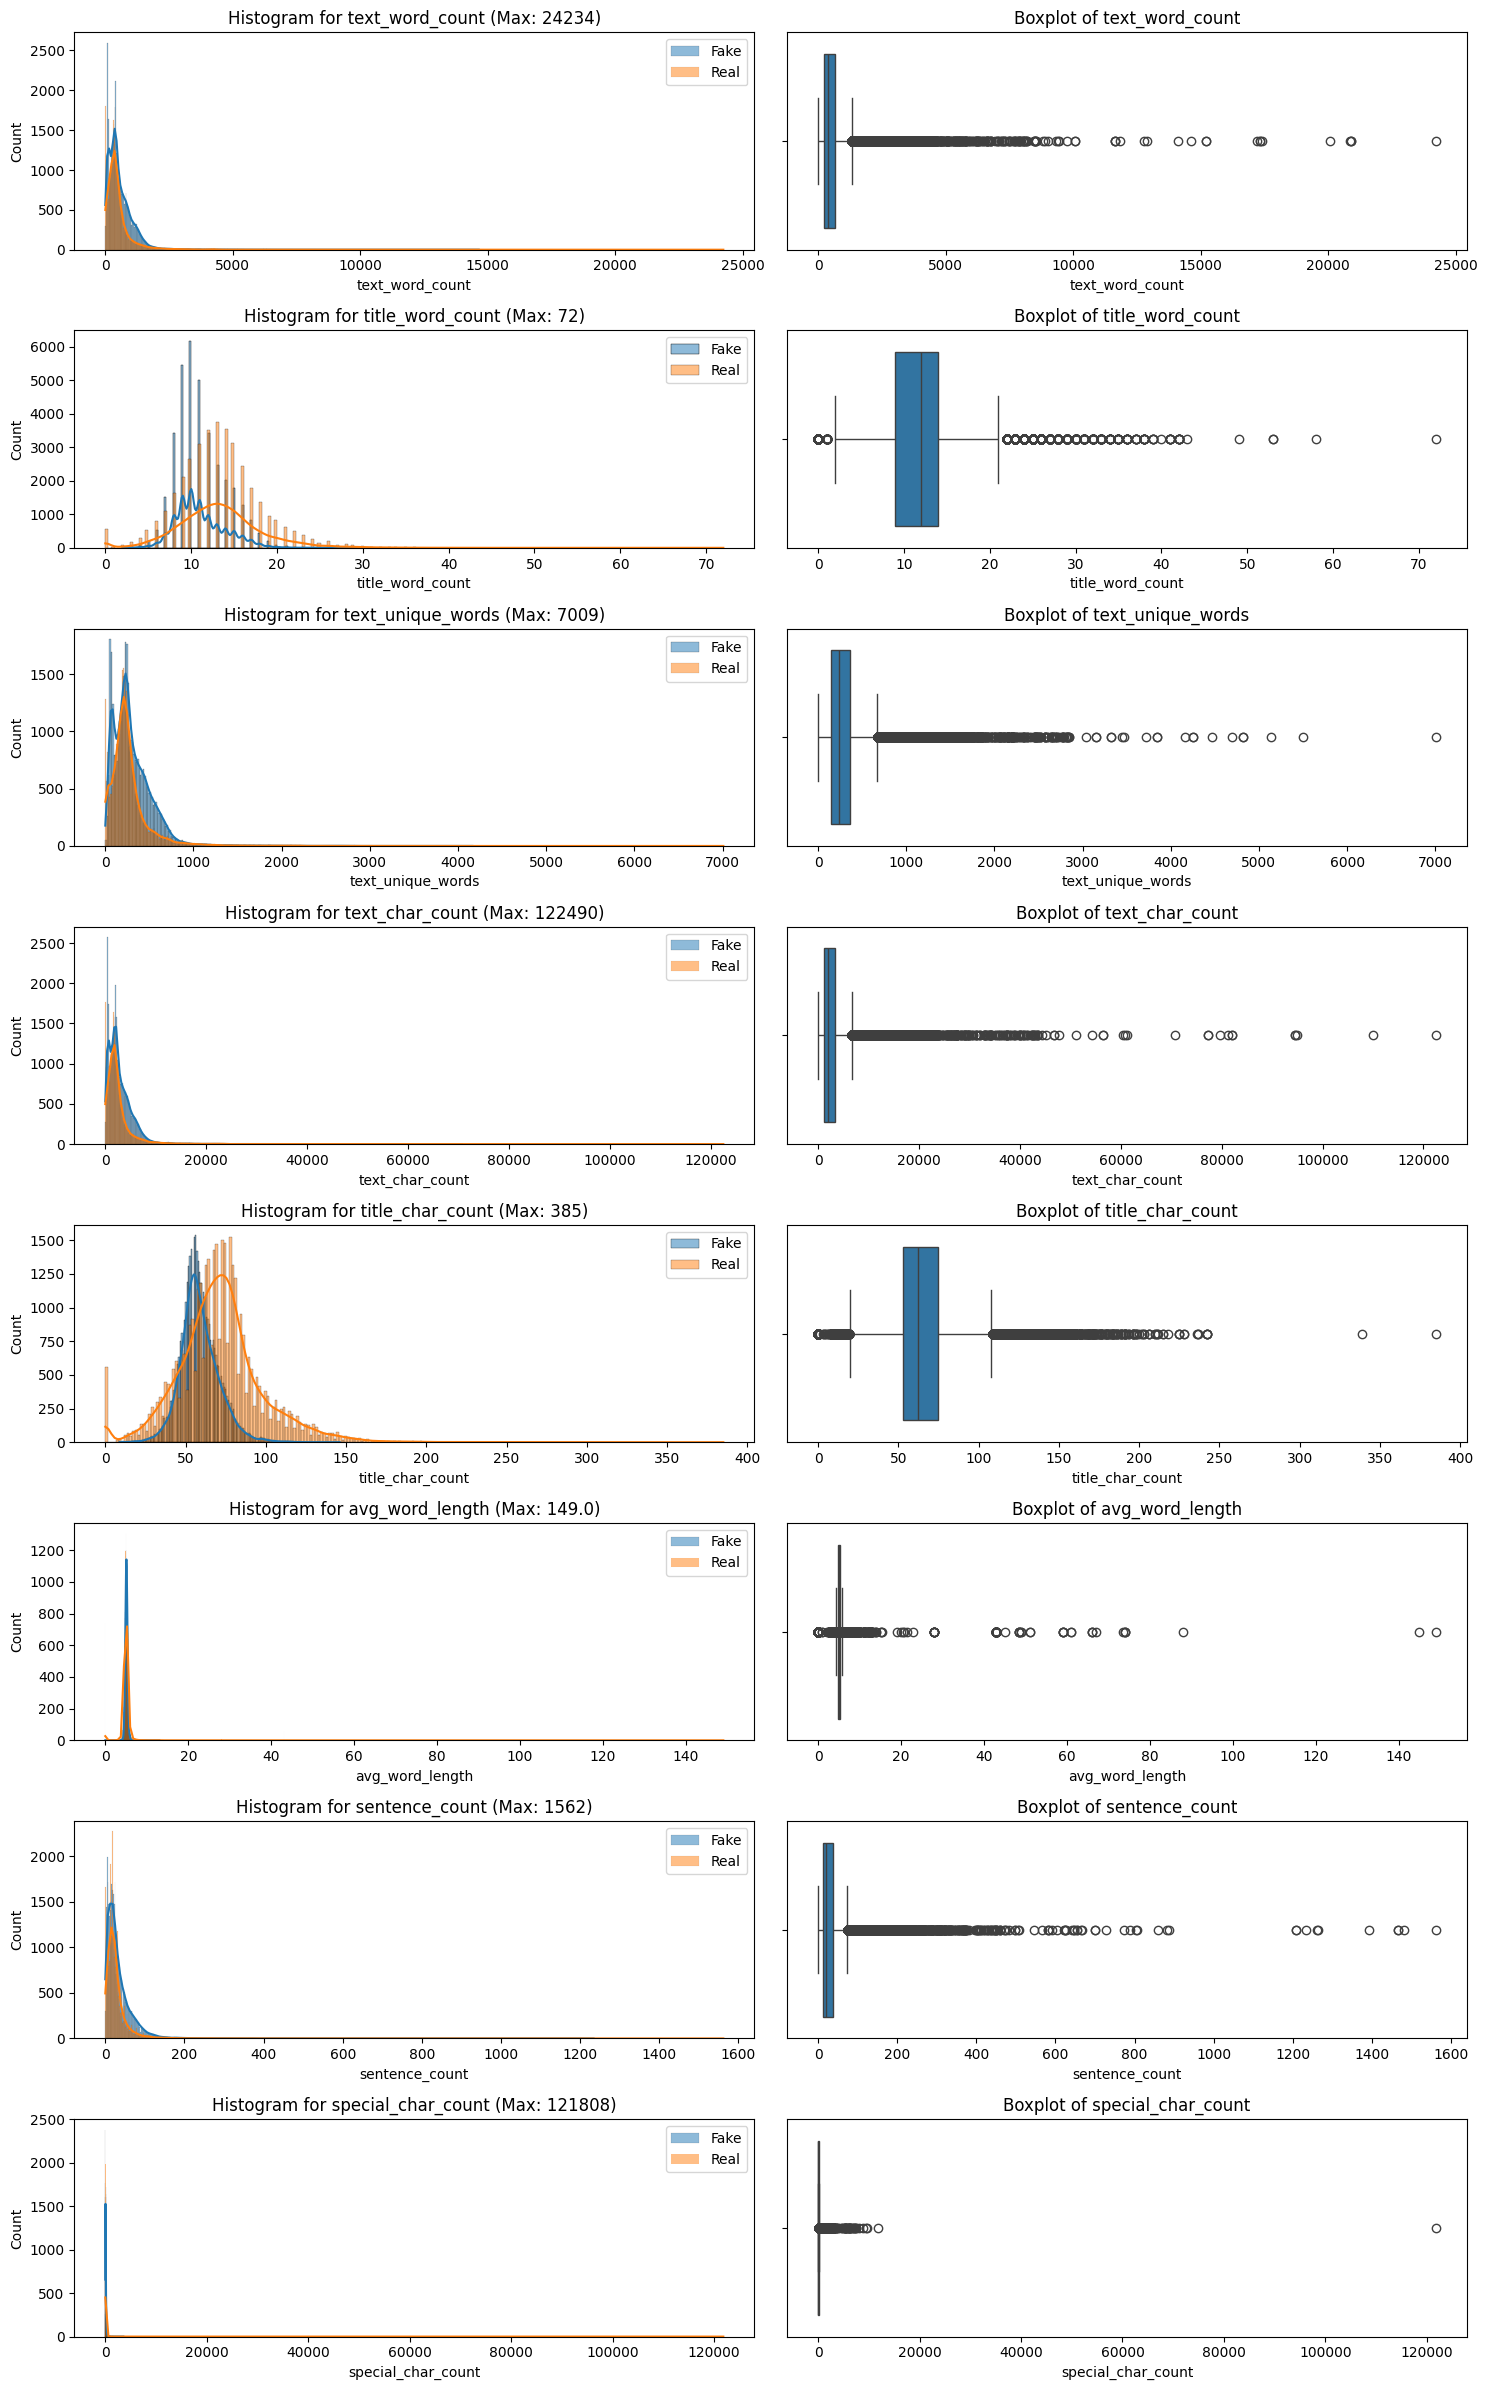

In [41]:
plot_histograms_and_boxplots(df, num_cols)

# Potential Outliers

There are data points that significantly skew the distribution. Given the small number of data points used to determine the target category, these should be carefully examined as potential outliers, as they may disproportionately influence the analysis or model performance.

Remove potential outliers and check distributions again.

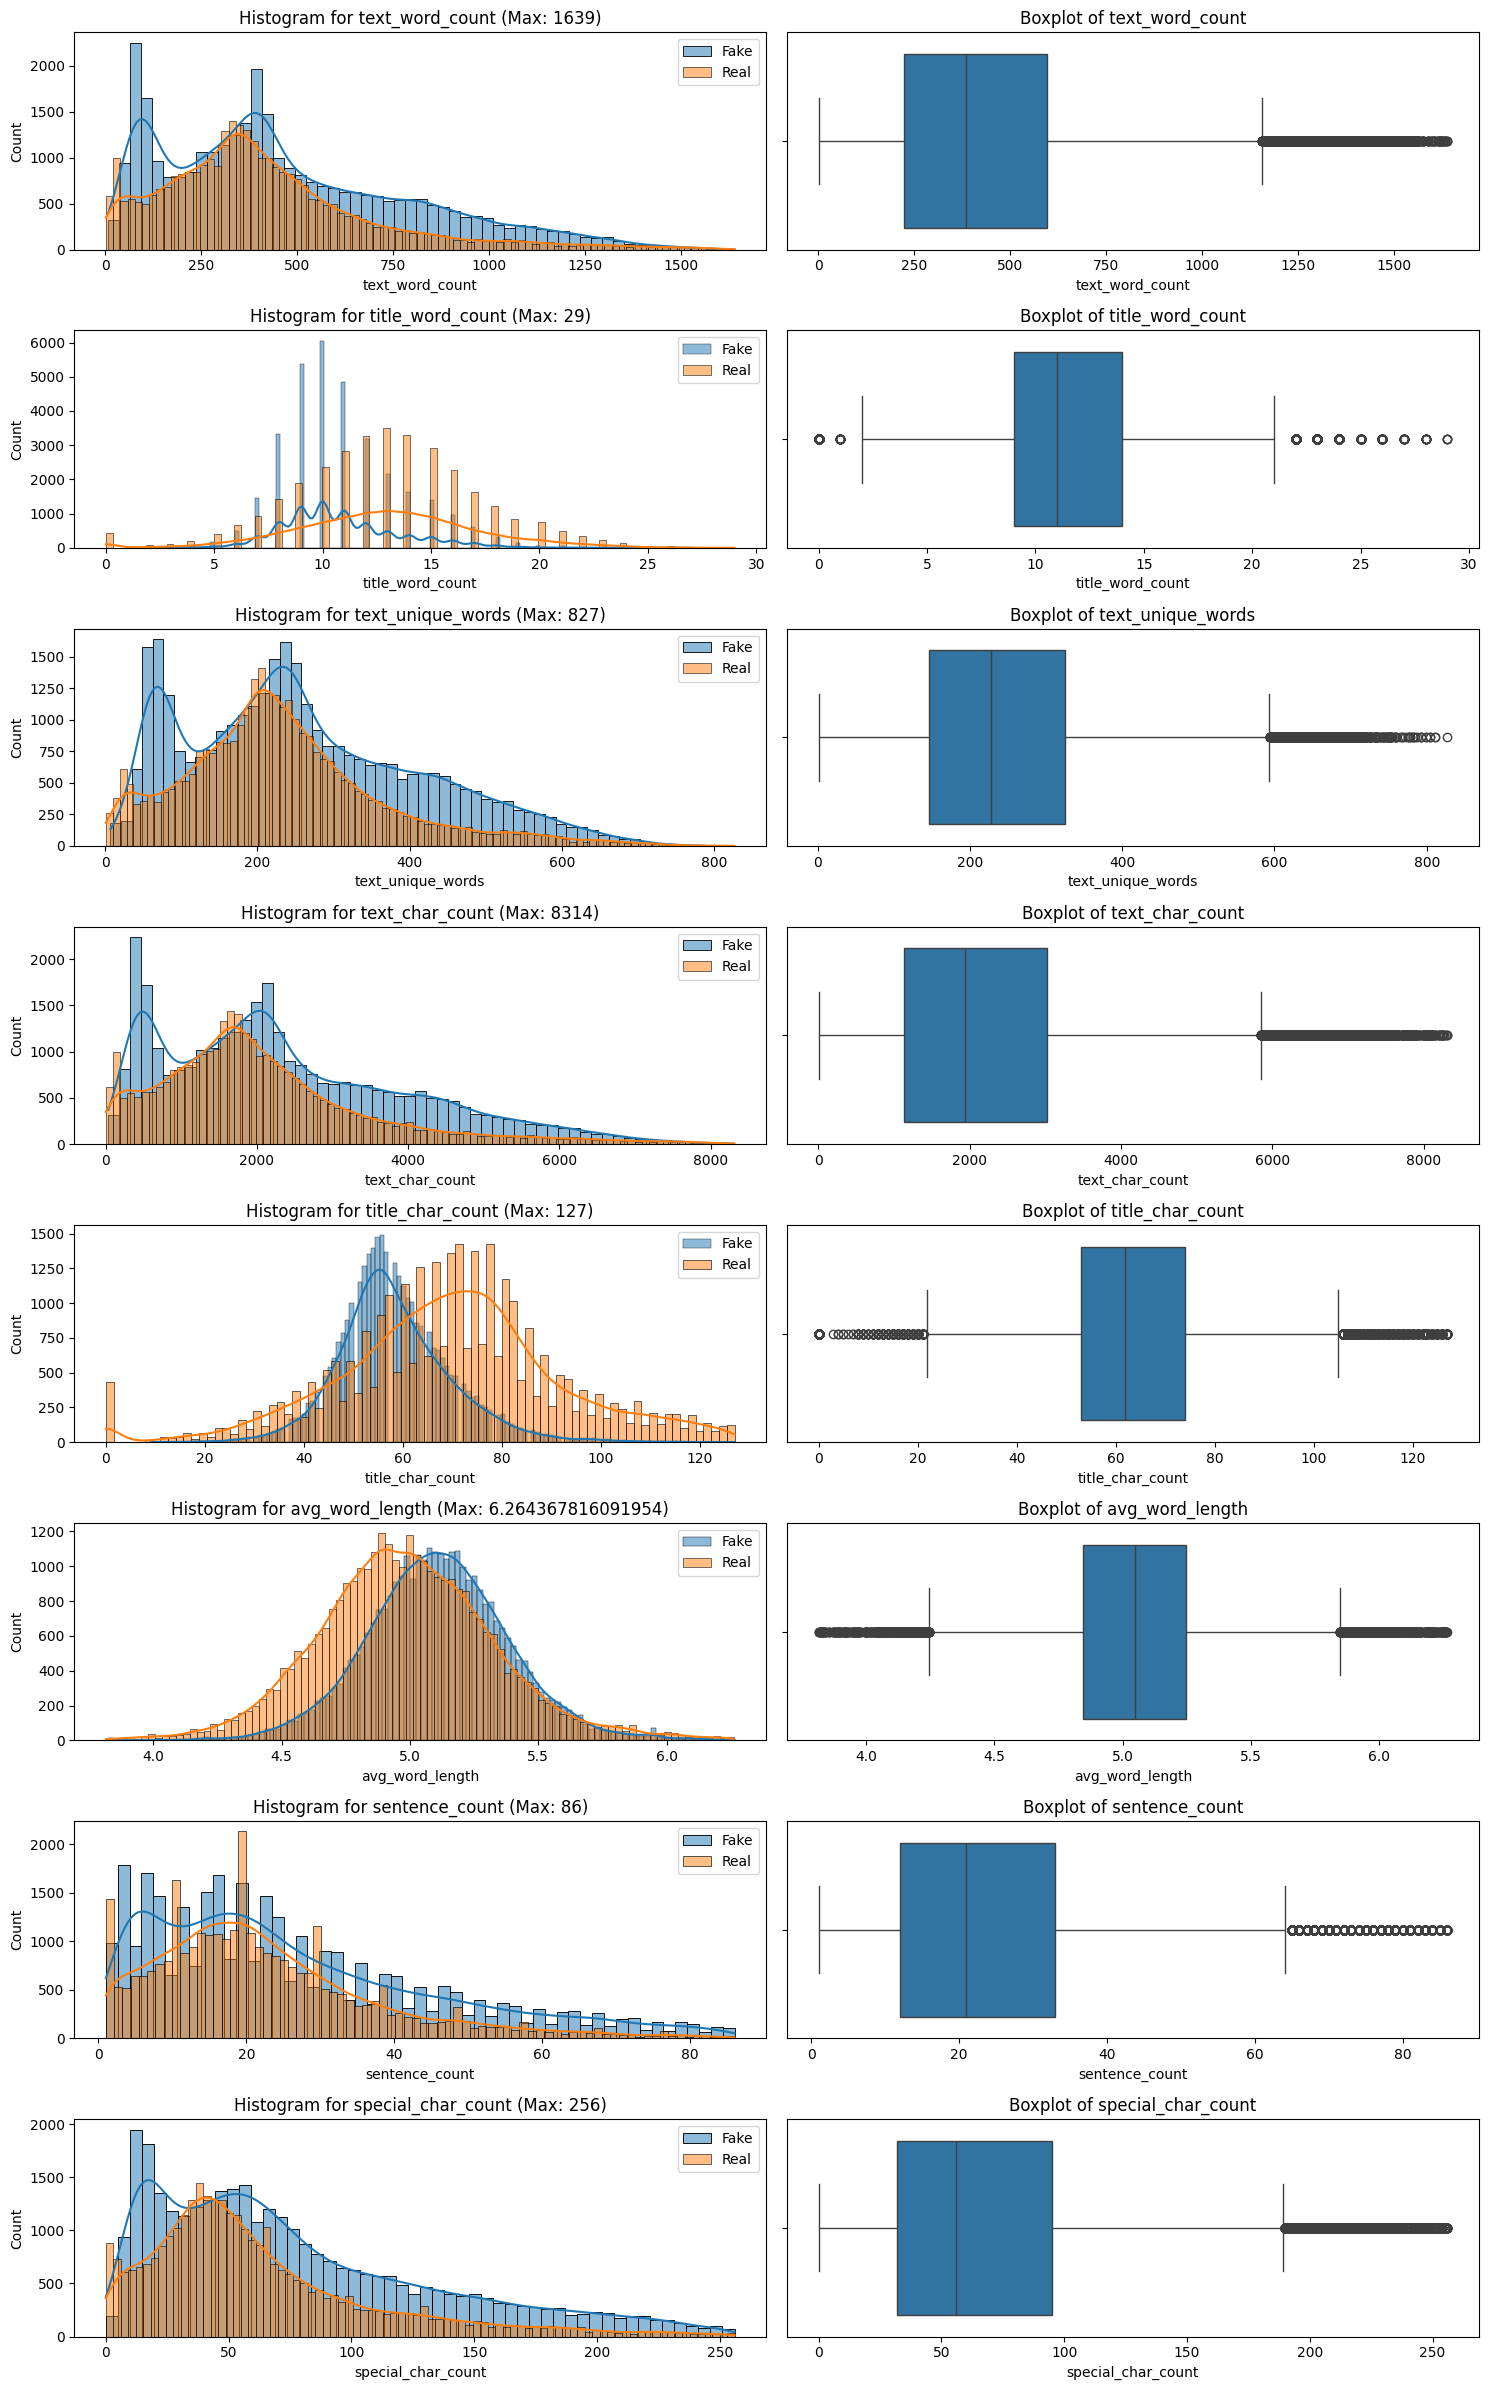

In [58]:
plot_histograms_and_boxplots(remove_outliers_mad(df, num_cols, threshold=6), num_cols)

# Check distribution of the target

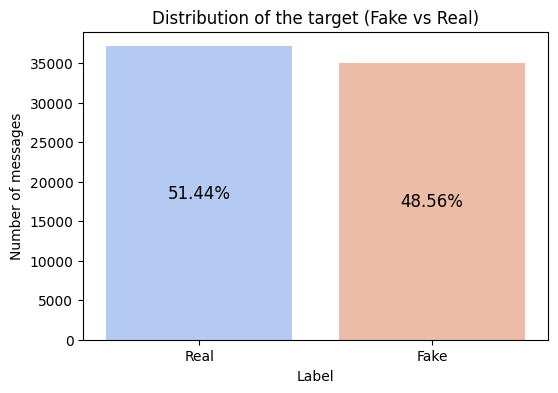

In [56]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df, palette='coolwarm')
plt.title('Distribution of the target (Fake vs Real)')
ax.set_xticklabels(['Real', 'Fake'])
plt.xlabel('Label')
plt.ylabel('Number of messages')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    # percentage = f'{df.label.mean() * 100:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12)
    
plt.show()

# Plot WordCloud

In [11]:
df[['title', 'text']] = df[['title', 'text']].fillna("")

In [12]:
fake_news = df[df['label'] == 1]
real_news = df[df['label'] == 0]
fake_texts = ' '.join(text for text in fake_news['text'])
real_texts = ' '.join(text for text in real_news['text'])

# WordCloud for Fake News

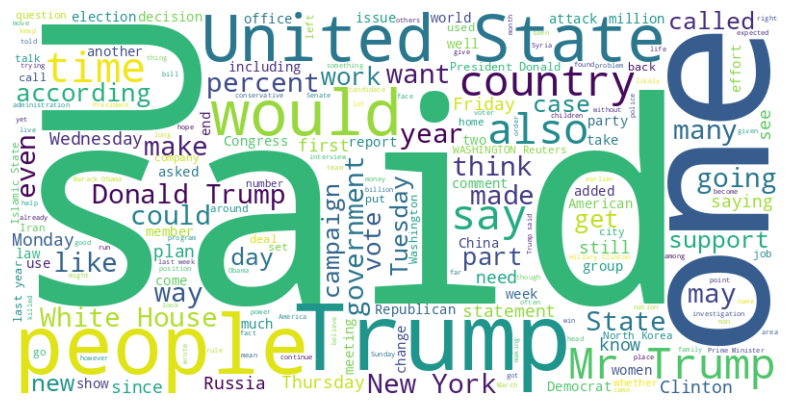

In [14]:
plot_WordCloud(fake_texts)

# WordCloud for Real News

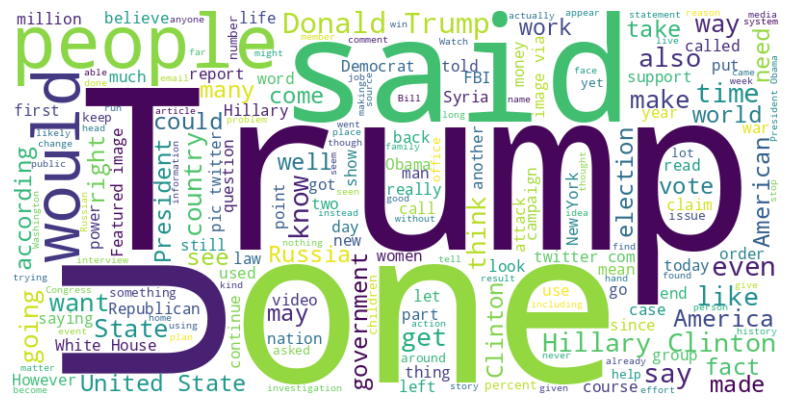

In [15]:
plot_WordCloud(real_texts)

In [16]:
# Most common words without stopwords

def get_most_common_words(texts, n=20):
    words = ' '.join(texts).split()
    filtered_words = [word.lower() for word in words if word.lower() not in stopWords and word.isalpha()]
    most_common = Counter(filtered_words).most_common(n)
    return pd.DataFrame(most_common, columns=['Word', 'Frequency'])

most_common_words = get_most_common_words(df['text'].dropna(), n=20)
print("\nMost common words (without stopwords):")
print(most_common_words)


Most common words (without stopwords):
          Word  Frequency
0         said     153964
1        trump     153926
2        would     104301
3          one      78176
4       people      73215
5    president      71183
6          new      68693
7         also      63367
8         like      52277
9      clinton      52074
10       could      49194
11       state      47568
12        even      42154
13      united      41970
14         two      40953
15      donald      40875
16        many      40132
17        last      39336
18  government      39103
19       obama      38027


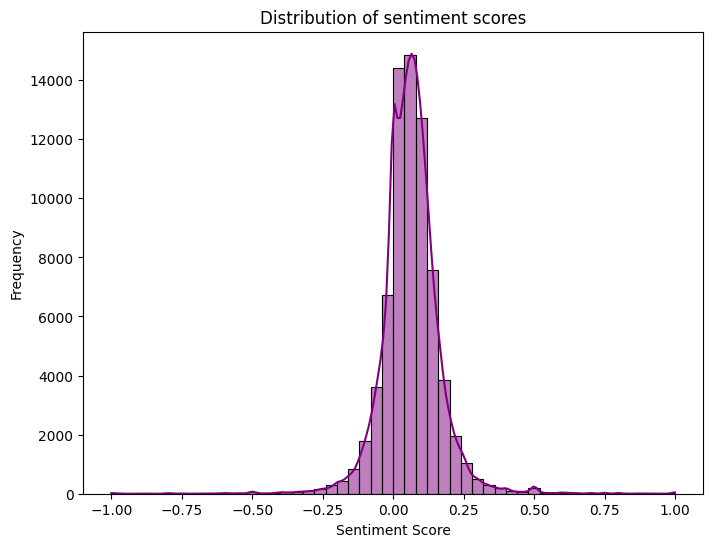

In [17]:
# Sentiment Analysis

def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], bins=50, kde=True, color='purple')
plt.title('Distribution of sentiment scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## EDA Completed – Key Findings:
The exploratory data analysis (EDA) has been completed, revealing several important insights:

* The target variable is **evenly distributed**. However, since the dataset has been compiled from various sources, it appears to have already undergone **resampling**.
* A total of **10,740 duplicate** rows exist in either the text or title columns, affecting **15% of the dataset**. Notably, only **1% of these duplicates belong to the "Fake News" category**, meaning their removal is necessary to prevent duplicates from entering the validation and test datasets, though it would significantly impact the target variable's distribution.

## Feature Engineering:
New features were generated during the EDA and can also be utilized for modeling:

* **title_text**: Concatenation of the title and text columns.
* **text_word_count**: Number of words in the text column.
* **title_word_count**: Number of words in the title column.
* **text_unique_words**: Number of unique words in the text column.
* **text_char_count**: Number of characters in the text column.
* **title_char_count**: Number of characters in the title column.
* **avg_word_length**: Average word length in the text column.
* **sentence_count**: Number of sentences in the text column.
* **special_char_count**: Number of special characters in the text column.
* **language**: Estimated language of the text column.

## Handling Missing Values:
The dataset contains missing values, which are replaced with **empty strings**. This ensures that concatenating the title and text columns does not result in NaN values.

## Outliers & Distribution Analysis:
* The **difference between the mean and median** across all numerical features, along with **strong right-skewed distributions**, indicates **potential outliers** in the dataset. These could significantly impact on model performance.
* Outliers were **identified with Median absolut deviation**
* **Empty entries in text column**.
* **Entries with text_word_count > 0 & < 6**, which cannot be considered meaningful messages. Most single-word entries consist solely of a URL.
* Since **non-English entries are rare and sparsely represented** in the dataset, they are classified as **potential outliers**.

# Impact on Modeling:
To assess the effect of outliers on model performance, two datasets will be tested:

1. **Dataset excluding outliers**
2. **Dataset including outliers**

The evaluation process will follow these steps:

1. **Step 1**: Ignore outliers and develop the model without them.
2. **Step 2**: Check the model’s performance on the outliers.
3. **Step 3**: If outliers are absolutely necessary, re-train the model with them.

## Feature Selection & Multicollinearity:
Some of the newly created features show **strong intercorrelation**. Therefore, a **dedicated feature selection process** will be required, which will be performed during the modeling phase.

# Prepare dataset for modeling

In [10]:
df = pd.read_csv('./data/WELFake_Dataset.csv')

data cleaning

In [11]:
df = clean_data(df)

Prepare features

In [ ]:
# df = prepare_features(df)

In [14]:
from spacy.lang.en.examples import sentences
nlp = spacy.load('en_core_web_sm')
type(nlp)

spacy.lang.en.English

In [13]:
# save punctuations and print them
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [39]:
re.sub(r'[\■🚨]+', '', df['title_text'][11165])

"Bill Clinton and Hillary Lolita Express Pedophilia Ring Bill Clinton and Hillary Lolita Express Pedophilia Ring 11/04/2016 In today’s video, Christopher Greene of AMTV breaks down the connection between convicted felon Jefferey Epstein ‘known pedophile” and the Clinton’s. Will this be the next shoe to drop in the Wikileaks Podesta dump? Will find out this weekend in an Exclusive RT interview with the man himself Julian Assange. Analyst: Most Americans like neither Candidate 11/04/2016 PRESS TV US Democratic presidential candidate Hillary Clinton’s unpopularity among American voters has reached a new h ... Crack in Earth’s magnetic shield detected 11/04/2016 DNA INDIA The world's largest and most sensitive cosmic ray monitor, located in India, has recorded a burst of galact ... Feds warn NYC officials about possible al Qaeda attack 11/04/2016 NEW YORK POST New York City law enforcement authorities are on high alert after receiving a warning by the feds about ... AMTV Archives"

In [43]:
text_cleaner(df['title_text'][12811])

'„ duelist martin wuttkes neuer tatort film deutschland und russland der neue film des regisseurs alexei misgirew zeigt russland 19 jahrhundert sankt petersburg sprach damal schon deutsch quelle kinopoisk ru alexei misgirews film „ duellant duelist stieß schon während der produktion auf große resonanz der internationalen filmindustrie seine weltpremiere feierte der streifen schließlich auf dem toronto film festival eine kooperation mit imax ermöglicht nun seinen verleih den usa und einigen anderen ländern bis zu diesem erfolg hatte misgirew russland den ruf eine regisseurs der zweiten reihe seine filme kaman alle nur den begrenzten verleih sie ein publikum von wenigen tausend zuschauern erreichten jetzt realisierte misgirew zusamman mit dem produzenten alexander rodnianski „ jayne mansfield ’s car „ cloud atlas „ leviathan eine der größten projekte der geschichte des neueren russischen kinos „ duelist ist ein den 1860er jahren spielende kostümdrama über einen auftragsmörder der held de

To use the title and text columns for modeling, they were combined into a new feature called title_text within the prepare_features function. The text_cleaner function is then applied to this new column and creates a new feature called title_text_cleaned.

In [ ]:
# Apply text_cleaner
from tqdm import tqdm

# Progress bar
results = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Progress"):
    results.append(text_cleaner(row['title_text']))

df['title_text_clean'] = results

Progress:   1%|▏                                     | 439/72134 [00:43<3:18:17,  6.03it/s]

In [ ]:
df.head()

In [3]:
path = './data/Dataset_cleaned.csv'

In [14]:
with open(path, 'w', encoding='utf-8', newline='') as file:
    df.to_csv(file, index=False)

print(f"CSV file was successfully saved under: {path}")

CSV file was successfully saved under: ./data/Dataset_cleaned.csv


In [4]:
with open(path, 'r', encoding='utf-8') as file:
    df_cleaned = pd.read_csv(file)

df_cleaned.head()

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,sentiment,title_text_clean
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,0.033103,law enforcement high alert follow threats cops...
1,,Did they post their votes for Hillary already?,0,Did they post their votes for Hillary already?,8,0,8,39,0,4.875000,1,1,0.000000,post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,0.258929,unbelievable obama ’s attorney general say mos...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,0.113865,bobby jindal raise hindu use story christian c...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,0.056373,satan 2 russia unveli image terrifying new sup...
